# Abstract

We use the SUSY dataset and construct a neural network 
classifier, then apply dimensionality reduction via incrememntal PCA and retrain a network of similar architecture on this "reduced" dataset.
(Placeholder, we should probably rewrite this)

# Setup

Import the SUSY dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

--2021-04-25 02:18:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘SUSY.csv.gz’

SUSY.csv.gz         100%[===================>] 879.65M  37.9MB/s    in 21s     

2021-04-25 02:18:54 (42.2 MB/s) - ‘SUSY.csv.gz’ saved [922377711/922377711]



In [ ]:
!gzip -d SUSY.csv.gz

In [ ]:
import pandas as pd
data = pd.read_csv('./SUSY.csv')

Define X and y as a subset of SUSY.csv (or the entire dataset, commented)


In [ ]:
#All features: 8 low-level, 10 high-level
X=data.iloc[:50000,1:]
y=data.iloc[:50000,0]

#Full dataset
#X=data.iloc[:,1:]
#y=data.iloc[:,0]

Create the test, train, and validation sets from X and y

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

# Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import time

In [ ]:
num_dims = (np.shape(X_train))[1]
print(num_dims)

18


Everytime we create a model, we will call this function, create_model(). This way, every model will have the same architecture after the input layer.

In [ ]:
from keras.layers import BatchNormalization

def create_model():
  model = keras.models.Sequential()
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))
  return model

Here we define the optimizer which we will use with all models.

In [ ]:
#exp_opt = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.05,
#    decay_steps=10000,
#    decay_rate=1e-5)

opt = keras.optimizers.Adam()


#model.compile(loss='categorical_crossentropy', optimizer=exp_opt)

In [ ]:
model_primary = create_model()
model_primary.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model_primary.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10)

Epoch 1/20
3200/3200 [==============================] - 14s 3ms/step - loss: 0.5734 - accuracy: 0.7262 - val_loss: 0.4774 - val_accuracy: 0.7819
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4973 - accuracy: 0.7691 - val_loss: 0.4514 - val_accuracy: 0.7923
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4912 - accuracy: 0.7686 - val_loss: 0.4499 - val_accuracy: 0.7938
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4848 - accuracy: 0.7756 - val_loss: 0.4678 - val_accuracy: 0.7936
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4919 - accuracy: 0.7702 - val_loss: 0.4596 - val_accuracy: 0.7800
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4786 - accuracy: 0.7817 - val_loss: 0.4561 - val_accuracy: 0.7950
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4739 - accuracy: 0.7825 - val_loss: 0.4501 - val_ac

In [ ]:
model_primary.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (10, 300)                 5700      
_________________________________________________________________
batch_normalization (BatchNo (10, 300)                 1200      
_________________________________________________________________
dense_1 (Dense)              (10, 300)                 90300     
_________________________________________________________________
batch_normalization_1 (Batch (10, 300)                 1200      
_________________________________________________________________
dense_2 (Dense)              (10, 300)                 90300     
_________________________________________________________________
batch_normalization_2 (Batch (10, 300)                 1200      
_________________________________________________________________
dense_3 (Dense)              (10, 300)                 9

Evaluate the performance of the model.

In [ ]:
_, accuracy = model_primary.evaluate(X_test, y_test)

250/250 [==============================] - 1s 2ms/step - loss: 0.4604 - accuracy: 0.7894


In [ ]:
from sklearn.metrics import roc_curve, auc

# Evaluate on validation set
score = model_primary.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model_primary.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

313/313 [==============================] - 1s 2ms/step - loss: 0.4441 - accuracy: 0.7985

Validation loss / accuracy: 0.4441 / 0.7985
Validation ROC AUC: 0.8697786581516537
250/250 [==============================] - 1s 2ms/step - loss: 0.4604 - accuracy: 0.7894

Test loss / accuracy: 0.4604 / 0.7894
Test ROC AUC: 0.8599218823529412


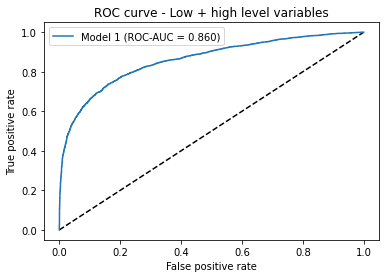

In [ ]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Low + high level variables')
plt.legend(loc='best')
plt.show()

# Principal Component Analysis

We perform PCA to reduce our data set's dimensionality.

In [ ]:
#This is the number of dimensions that we want to reduce our dataset to using dimensionality reduction.
reduced_dims = 15

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca = IncrementalPCA(n_components=reduced_dims)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_train_reduced = inc_pca.transform(X_train)
X_val_reduced = inc_pca.transform(X_val)
X_test_reduced = inc_pca.transform(X_test)

In [ ]:
np.shape(X_train_reduced[1])

(15,)

# Retraining the Neural Network


In [ ]:
model_reduced = create_model()
model_reduced.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_reduced.fit(X_train_reduced, y_train, validation_data=(X_val_reduced, y_val), epochs=20, batch_size=10)

Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5617 - accuracy: 0.7409 - val_loss: 0.4589 - val_accuracy: 0.7896
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4902 - accuracy: 0.7760 - val_loss: 0.4504 - val_accuracy: 0.7946
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4818 - accuracy: 0.7768 - val_loss: 0.4581 - val_accuracy: 0.7902
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4832 - accuracy: 0.7750 - val_loss: 0.4502 - val_accuracy: 0.7872
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4778 - accuracy: 0.7760 - val_loss: 0.4545 - val_accuracy: 0.7969
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4746 - accuracy: 0.7798 - val_loss: 0.4463 - val_accuracy: 0.7988
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4766 - accuracy: 0.7806 - val_loss: 0.4452 - val_ac

# Evaluation of the Reduced Dimensions

In [ ]:
# Evaluate on validation set
score = model_reduced.evaluate(X_val_reduced, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred_reduced = model_reduced.predict(X_val_reduced)
fpr, tpr, _ = roc_curve(y_val, y_pred_reduced)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model_reduced.evaluate(X_test_reduced, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred_reduced = model_reduced.predict(X_test_reduced)
fpr, tpr, _ = roc_curve(y_test, y_pred_reduced)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

313/313 [==============================] - 1s 2ms/step - loss: 0.4453 - accuracy: 0.7977

Validation loss / accuracy: 0.4453 / 0.7977
Validation ROC AUC: 0.8675514488486917
250/250 [==============================] - 1s 2ms/step - loss: 0.4581 - accuracy: 0.7886

Test loss / accuracy: 0.4581 / 0.7886
Test ROC AUC: 0.8595621960784313


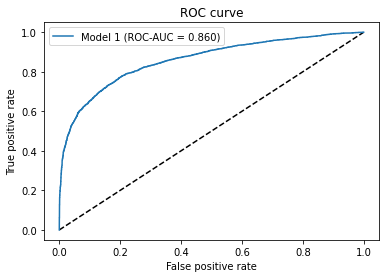

In [ ]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Testing various numbers of reduced dimensions

Here we test across a range of numbers of reduced dimensions.

Note: This will take a long time to run in comparison to the rest of the notebook, since we are training several networks in a loop.

Model 1 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6637 - accuracy: 0.6379 - val_loss: 0.6110 - val_accuracy: 0.6610
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6337 - accuracy: 0.6373 - val_loss: 0.6124 - val_accuracy: 0.6610
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6325 - accuracy: 0.6458 - val_loss: 0.6231 - val_accuracy: 0.6375
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6343 - accuracy: 0.6389 - val_loss: 0.6201 - val_accuracy: 0.6236
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6246 - accuracy: 0.6501 - val_loss: 0.6318 - val_accuracy: 0.6485
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6280 - accuracy: 0.6433 - val_loss: 0.6198 - val_accuracy: 0.6590
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6168 - accuracy: 0.6592 - val_loss: 0

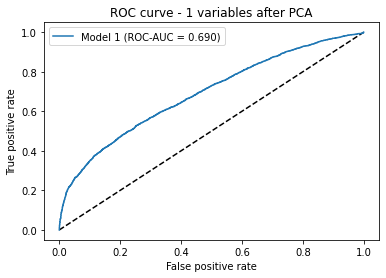

Model 2 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6182 - accuracy: 0.6903 - val_loss: 0.5594 - val_accuracy: 0.7241
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5758 - accuracy: 0.7118 - val_loss: 0.5589 - val_accuracy: 0.7289
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5818 - accuracy: 0.7012 - val_loss: 0.5513 - val_accuracy: 0.7272
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5709 - accuracy: 0.7145 - val_loss: 0.5564 - val_accuracy: 0.7282
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5681 - accuracy: 0.7186 - val_loss: 0.5481 - val_accuracy: 0.7259
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5740 - accuracy: 0.7119 - val_loss: 0.5583 - val_accuracy: 0.7217
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5714 - accuracy: 0.7107 - val_loss: 0

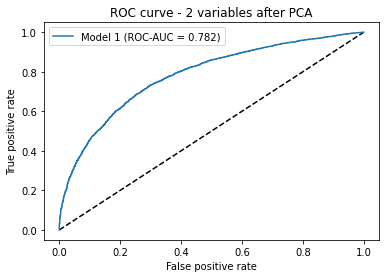

Model 3 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6189 - accuracy: 0.6933 - val_loss: 0.5451 - val_accuracy: 0.7260
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5664 - accuracy: 0.7155 - val_loss: 0.5487 - val_accuracy: 0.7337
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5660 - accuracy: 0.7115 - val_loss: 0.5506 - val_accuracy: 0.7271
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5666 - accuracy: 0.7137 - val_loss: 0.5444 - val_accuracy: 0.7288
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5679 - accuracy: 0.7173 - val_loss: 0.5415 - val_accuracy: 0.7320
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5577 - accuracy: 0.7211 - val_loss: 0.5408 - val_accuracy: 0.7332
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5580 - accuracy: 0.7179 - val_loss: 0

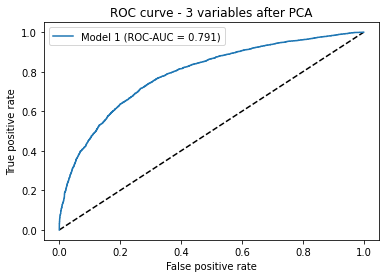

Model 4 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6163 - accuracy: 0.6992 - val_loss: 0.5562 - val_accuracy: 0.7252
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5682 - accuracy: 0.7153 - val_loss: 0.5368 - val_accuracy: 0.7324
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5619 - accuracy: 0.7229 - val_loss: 0.5416 - val_accuracy: 0.7276
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5650 - accuracy: 0.7098 - val_loss: 0.5394 - val_accuracy: 0.7306
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5612 - accuracy: 0.7192 - val_loss: 0.5385 - val_accuracy: 0.7343
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5582 - accuracy: 0.7146 - val_loss: 0.5333 - val_accuracy: 0.7311
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5522 - accuracy: 0.7214 - val_loss: 0

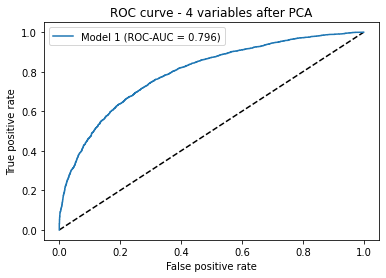

Model 5 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6269 - accuracy: 0.6962 - val_loss: 0.5569 - val_accuracy: 0.7204
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5704 - accuracy: 0.7103 - val_loss: 0.5345 - val_accuracy: 0.7280
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5634 - accuracy: 0.7182 - val_loss: 0.5316 - val_accuracy: 0.7361
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5518 - accuracy: 0.7221 - val_loss: 0.5280 - val_accuracy: 0.7339
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5515 - accuracy: 0.7220 - val_loss: 0.5222 - val_accuracy: 0.7415
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5461 - accuracy: 0.7278 - val_loss: 0.5198 - val_accuracy: 0.7416
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5489 - accuracy: 0.7223 - val_loss: 0

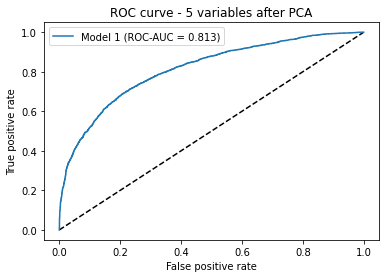

Model 6 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5973 - accuracy: 0.7105 - val_loss: 0.5211 - val_accuracy: 0.7322
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5367 - accuracy: 0.7339 - val_loss: 0.5045 - val_accuracy: 0.7517
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5353 - accuracy: 0.7349 - val_loss: 0.5054 - val_accuracy: 0.7476
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5298 - accuracy: 0.7348 - val_loss: 0.5041 - val_accuracy: 0.7488
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5313 - accuracy: 0.7299 - val_loss: 0.5056 - val_accuracy: 0.7530
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5244 - accuracy: 0.7400 - val_loss: 0.5060 - val_accuracy: 0.7517
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5228 - accuracy: 0.7383 - val_loss: 0

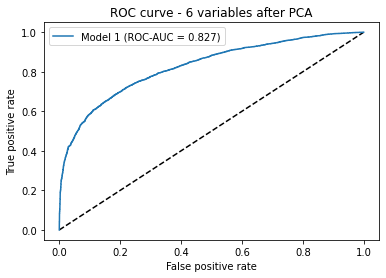

Model 7 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6010 - accuracy: 0.7025 - val_loss: 0.5160 - val_accuracy: 0.7450
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5464 - accuracy: 0.7239 - val_loss: 0.5073 - val_accuracy: 0.7481
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5356 - accuracy: 0.7306 - val_loss: 0.5118 - val_accuracy: 0.7467
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5314 - accuracy: 0.7279 - val_loss: 0.5054 - val_accuracy: 0.7527
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5292 - accuracy: 0.7353 - val_loss: 0.5056 - val_accuracy: 0.7477
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5251 - accuracy: 0.7328 - val_loss: 0.4970 - val_accuracy: 0.7543
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5254 - accuracy: 0.7328 - val_loss: 0

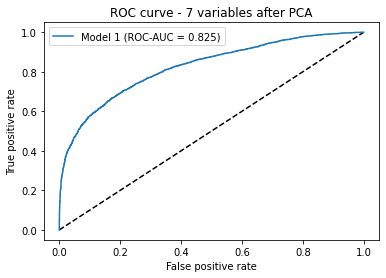

Model 8 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5805 - accuracy: 0.7223 - val_loss: 0.4992 - val_accuracy: 0.7636
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5332 - accuracy: 0.7376 - val_loss: 0.4906 - val_accuracy: 0.7708
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5227 - accuracy: 0.7459 - val_loss: 0.4919 - val_accuracy: 0.7657
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5113 - accuracy: 0.7517 - val_loss: 0.4920 - val_accuracy: 0.7692
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5154 - accuracy: 0.7469 - val_loss: 0.4843 - val_accuracy: 0.7719
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5121 - accuracy: 0.7505 - val_loss: 0.4801 - val_accuracy: 0.7747
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5069 - accuracy: 0.7551 - val_loss: 0

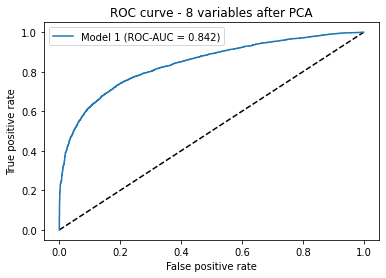

Model 9 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5861 - accuracy: 0.7196 - val_loss: 0.4915 - val_accuracy: 0.7646
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5212 - accuracy: 0.7476 - val_loss: 0.4903 - val_accuracy: 0.7692
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5119 - accuracy: 0.7519 - val_loss: 0.4807 - val_accuracy: 0.7696
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5054 - accuracy: 0.7544 - val_loss: 0.4787 - val_accuracy: 0.7733
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5059 - accuracy: 0.7565 - val_loss: 0.4787 - val_accuracy: 0.7737
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4996 - accuracy: 0.7594 - val_loss: 0.4731 - val_accuracy: 0.7750
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4950 - accuracy: 0.7622 - val_loss: 0

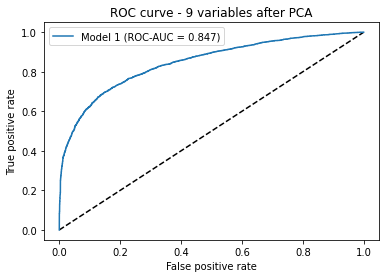

Model 10 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5537 - accuracy: 0.7452 - val_loss: 0.4765 - val_accuracy: 0.7873
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4953 - accuracy: 0.7656 - val_loss: 0.4551 - val_accuracy: 0.7865
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4831 - accuracy: 0.7778 - val_loss: 0.4638 - val_accuracy: 0.7877
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4887 - accuracy: 0.7759 - val_loss: 0.4468 - val_accuracy: 0.7957
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4795 - accuracy: 0.7804 - val_loss: 0.4474 - val_accuracy: 0.7911
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4792 - accuracy: 0.7770 - val_loss: 0.4531 - val_accuracy: 0.7909
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4799 - accuracy: 0.7798 - val_loss: 

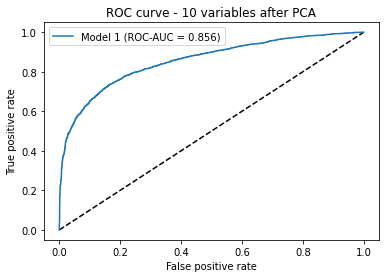

Model 11 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5757 - accuracy: 0.7316 - val_loss: 0.4514 - val_accuracy: 0.7949
Epoch 2/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4928 - accuracy: 0.7707 - val_loss: 0.4559 - val_accuracy: 0.7923
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4920 - accuracy: 0.7682 - val_loss: 0.4519 - val_accuracy: 0.7962
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4867 - accuracy: 0.7735 - val_loss: 0.4903 - val_accuracy: 0.7769
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4848 - accuracy: 0.7733 - val_loss: 0.4552 - val_accuracy: 0.7931
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4843 - accuracy: 0.7743 - val_loss: 0.4472 - val_accuracy: 0.7981
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4756 - accuracy: 0.7774 - val_loss: 

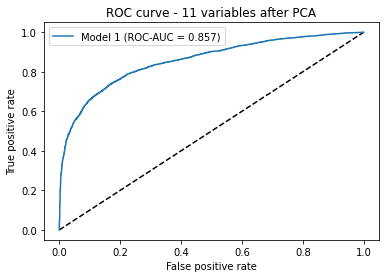

Model 12 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5510 - accuracy: 0.7422 - val_loss: 0.4517 - val_accuracy: 0.7904
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4906 - accuracy: 0.7740 - val_loss: 0.4532 - val_accuracy: 0.7914
Epoch 3/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4856 - accuracy: 0.7740 - val_loss: 0.4491 - val_accuracy: 0.7962
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4848 - accuracy: 0.7720 - val_loss: 0.4481 - val_accuracy: 0.7952
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4749 - accuracy: 0.7773 - val_loss: 0.4437 - val_accuracy: 0.7950
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4762 - accuracy: 0.7767 - val_loss: 0.4521 - val_accuracy: 0.7949
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4768 - accuracy: 0.7782 - val_loss: 

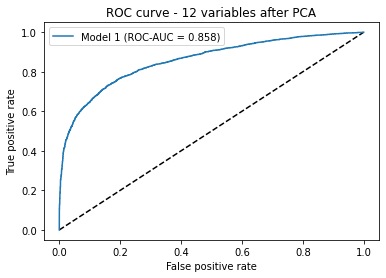

Model 13 of 17
Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5636 - accuracy: 0.7387 - val_loss: 0.4574 - val_accuracy: 0.7835
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4962 - accuracy: 0.7673 - val_loss: 0.4496 - val_accuracy: 0.7955
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4929 - accuracy: 0.7701 - val_loss: 0.4467 - val_accuracy: 0.7969
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4865 - accuracy: 0.7700 - val_loss: 0.4500 - val_accuracy: 0.7959
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4772 - accuracy: 0.7775 - val_loss: 0.4420 - val_accuracy: 0.7979
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4816 - accuracy: 0.7756 - val_loss: 0.4608 - val_accuracy: 0.7942
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4732 - accuracy: 0.7825 - val_loss: 

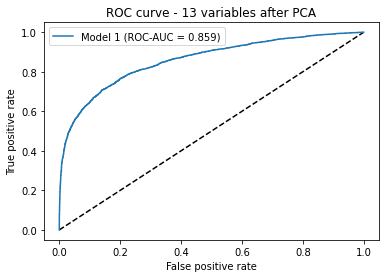

Model 14 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5592 - accuracy: 0.7419 - val_loss: 0.4530 - val_accuracy: 0.7912
Epoch 2/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4880 - accuracy: 0.7703 - val_loss: 0.4537 - val_accuracy: 0.7916
Epoch 3/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4887 - accuracy: 0.7739 - val_loss: 0.4512 - val_accuracy: 0.7939
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4779 - accuracy: 0.7794 - val_loss: 0.4469 - val_accuracy: 0.7928
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4788 - accuracy: 0.7773 - val_loss: 0.4455 - val_accuracy: 0.7950
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4726 - accuracy: 0.7797 - val_loss: 0.4519 - val_accuracy: 0.7950
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4701 - accuracy: 0.7839 - val_loss: 

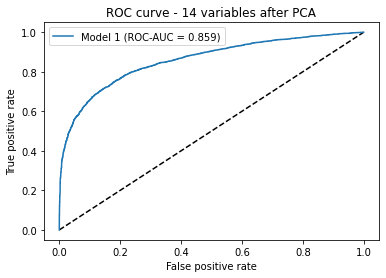

Model 15 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5570 - accuracy: 0.7440 - val_loss: 0.4678 - val_accuracy: 0.7798
Epoch 2/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4866 - accuracy: 0.7760 - val_loss: 0.4536 - val_accuracy: 0.7965
Epoch 3/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4823 - accuracy: 0.7766 - val_loss: 0.4513 - val_accuracy: 0.7973
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4835 - accuracy: 0.7760 - val_loss: 0.4477 - val_accuracy: 0.7988
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4797 - accuracy: 0.7758 - val_loss: 0.4442 - val_accuracy: 0.8003
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4750 - accuracy: 0.7803 - val_loss: 0.4482 - val_accuracy: 0.7989
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4719 - accuracy: 0.7826 - val_loss: 

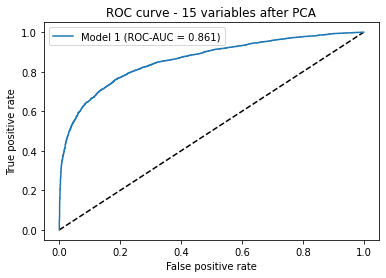

Model 16 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5538 - accuracy: 0.7412 - val_loss: 0.4733 - val_accuracy: 0.7873
Epoch 2/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4906 - accuracy: 0.7743 - val_loss: 0.4762 - val_accuracy: 0.7792
Epoch 3/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4859 - accuracy: 0.7720 - val_loss: 0.4409 - val_accuracy: 0.8006
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4787 - accuracy: 0.7796 - val_loss: 0.4587 - val_accuracy: 0.8001
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4749 - accuracy: 0.7790 - val_loss: 0.4427 - val_accuracy: 0.7961
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4735 - accuracy: 0.7849 - val_loss: 0.4504 - val_accuracy: 0.7966
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4663 - accuracy: 0.7842 - val_loss: 

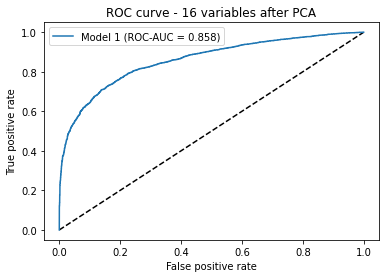

Model 17 of 17
Epoch 1/20
3200/3200 [==============================] - 12s 3ms/step - loss: 0.5670 - accuracy: 0.7376 - val_loss: 0.4475 - val_accuracy: 0.7976
Epoch 2/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4910 - accuracy: 0.7720 - val_loss: 0.4419 - val_accuracy: 0.7988
Epoch 3/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4849 - accuracy: 0.7772 - val_loss: 0.4451 - val_accuracy: 0.7995
Epoch 4/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4739 - accuracy: 0.7852 - val_loss: 0.4479 - val_accuracy: 0.7987
Epoch 5/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4668 - accuracy: 0.7847 - val_loss: 0.4463 - val_accuracy: 0.8001
Epoch 6/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4740 - accuracy: 0.7809 - val_loss: 0.4421 - val_accuracy: 0.7980
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.4674 - accuracy: 0.7851 - val_loss: 

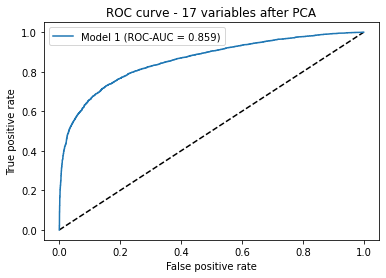

In [ ]:
inc_pcas = []
models = []
accuracies = []
aucs = []
losses = []
training_times = []

n_batches=100

cutoff = 17  #The maximum number of reduced dimensions we'll look at.
assert((0 < cutoff) and (cutoff < num_dims))

for d in range(1, cutoff+1):
  
  print("Model "+str(d)+" of "+str(cutoff))

  inc_pca = IncrementalPCA(n_components=d)
  for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
  inc_pcas.append(inc_pca)

  X_train_reduced = inc_pca.transform(X_train)
  X_val_reduced = inc_pca.transform(X_val)
  X_test_reduced = inc_pca.transform(X_test)

  model_reduced = create_model()
  model_reduced.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  t1 = time.perf_counter()
  model_reduced.fit(X_train_reduced, y_train, validation_data=(X_val_reduced, y_val), epochs=20, batch_size=10)
  t2 = time.perf_counter()
  models.append(model_reduced)
  training_times.append(t2-t1)

  loss, accuracy = model_reduced.evaluate(X_test_reduced, y_test)
  accuracies.append(accuracy)
  losses.append(loss)

  y_pred_reduced = model_reduced.predict(X_test_reduced)
  fpr, tpr, _ = roc_curve(y_test, y_pred_reduced)
  roc_auc = auc(fpr, tpr)  
  aucs.append(roc_auc)

  plt.plot([0, 1], [0, 1], 'k--')
  #plt.legend(loc=2, prop={'size': 15})
  plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve - %i variables after PCA' %d)
  plt.legend(loc='best')
  plt.show()


Now we add a classifier trained on the unmodified data.

In [ ]:
model_primary = create_model()
model_primary.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
t1 = time.perf_counter()
model_primary.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10)
t2 = time.perf_counter()
training_times.append(t2-t1)

Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5641 - accuracy: 0.7374 - val_loss: 0.4653 - val_accuracy: 0.7860
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4916 - accuracy: 0.7685 - val_loss: 0.4651 - val_accuracy: 0.7854
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4887 - accuracy: 0.7692 - val_loss: 0.4516 - val_accuracy: 0.7972
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4831 - accuracy: 0.7743 - val_loss: 0.4432 - val_accuracy: 0.7975
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4818 - accuracy: 0.7776 - val_loss: 0.4525 - val_accuracy: 0.7892
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4776 - accuracy: 0.7817 - val_loss: 0.4613 - val_accuracy: 0.7914
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4783 - accuracy: 0.7789 - val_loss: 0.4479 - val_ac

In [ ]:
loss_primary, acc_primary = model_primary.evaluate(X_test, y_test, verbose=1)
#print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_primary = auc(fpr, tpr)

250/250 [==============================] - 1s 2ms/step - loss: 0.4594 - accuracy: 0.7850


In [ ]:
models.append(model_primary)
accuracies.append(acc_primary)
aucs.append(roc_auc_primary)
losses.append(loss_primary)

In [ ]:
dims_array = []
for i in range(1, cutoff+2):
  dims_array.append(i)

Accuracies as a function of reduced dimensions

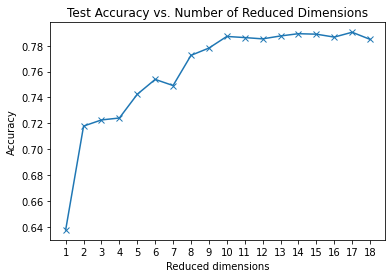

In [ ]:
plt.plot(dims_array, accuracies ,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Accuracy')
plt.xticks(dims_array)
plt.title("Test Accuracy vs. Number of Reduced Dimensions")
plt.show()

ROC AUC scores as a function of reduced dimensions

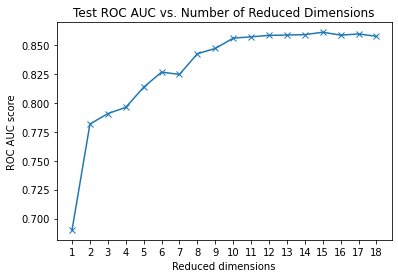

In [ ]:
plt.plot(dims_array, aucs, "x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('ROC AUC score')
plt.xticks(dims_array)
plt.title("Test ROC AUC vs. Number of Reduced Dimensions")
plt.show()

Loss (Binary Crossentropy) as a function of reduced dimensions

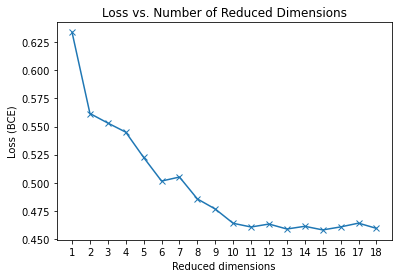

In [ ]:
plt.plot(dims_array, losses,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Loss (BCE)')
plt.xticks(dims_array)
plt.title("Loss vs. Number of Reduced Dimensions")
plt.show()

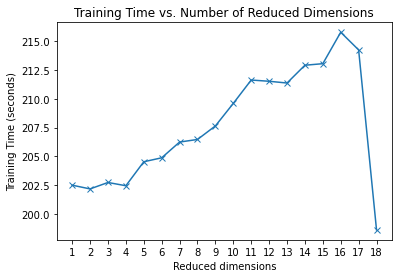

In [ ]:
plt.plot(dims_array, training_times,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Training Time (seconds)')
plt.xticks(dims_array)
plt.title("Training Time vs. Number of Reduced Dimensions")
plt.show()